# Color Matrices from datasheet values for the CMV12000

In this notebook we are going to try to calculate the color matrecies for the dng development of the CMOSIS cmv12000 from the spectral response found in the datasheet.
For this we have extracted the data from the plots on page 19 of the [datasheet](data_raw/CMV12000_DS000603_5-00.pdf) as csv into the [all.csv](data/all.csv) file using a mixture of inkscape,
[this plugin](https://github.com/camrbuss/nodes_to_csv) and then rescaling the data with a python script to match the real units.

loaded spectral data named 'red' from 300.0nm to 1100.0nm
loaded spectral data named 'green_red' from 300.0nm to 1100.0nm
loaded spectral data named 'blue' from 300.0nm to 1100.0nm


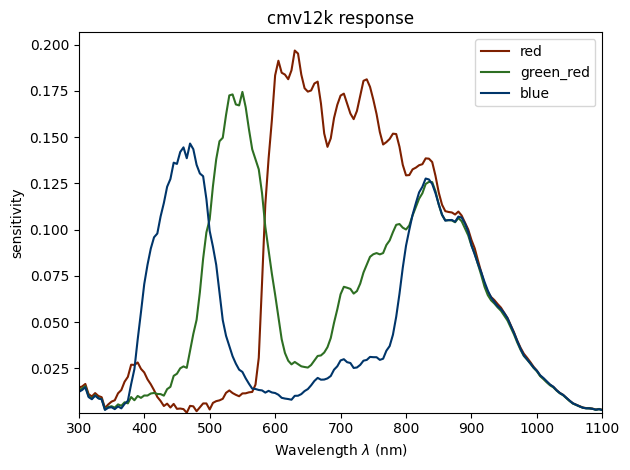

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'cmv12k response'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='sensitivity'>)

In [1]:
import numpy as np
import colour
from pathlib import Path

def load_spectral_data(filename):
    x, data = np.transpose(np.genfromtxt(filename, delimiter=",", skip_header=1))
    sd = colour.SpectralDistribution(data, x, name=Path(filename).stem)
    print(f"loaded spectral data named '{sd.name}' from {sd.wavelengths[0]}nm to {sd.wavelengths[-1]}nm")
    return sd

red = load_spectral_data("cmv12k_data/red.csv")
green = load_spectral_data("cmv12k_data/green_red.csv")
blue = load_spectral_data("cmv12k_data/blue.csv")

plot_kwargs = {'use_sd_colours': True}
colour.plotting.plot_multi_sds([red, green, blue], plot_kwargs=plot_kwargs, y_label="sensitivity", title="cmv12k response")


We Also normally have an UV/IR cut filter in front of the camera. Sebastian has measured three different filter types with a pectrometer to model that.

loaded spectral data named 'Hayda' from 300.0nm to 1100.0nm
loaded spectral data named 'Hoya' from 300.0nm to 1100.0nm
loaded spectral data named 'UQG' from 300.0nm to 1100.0nm


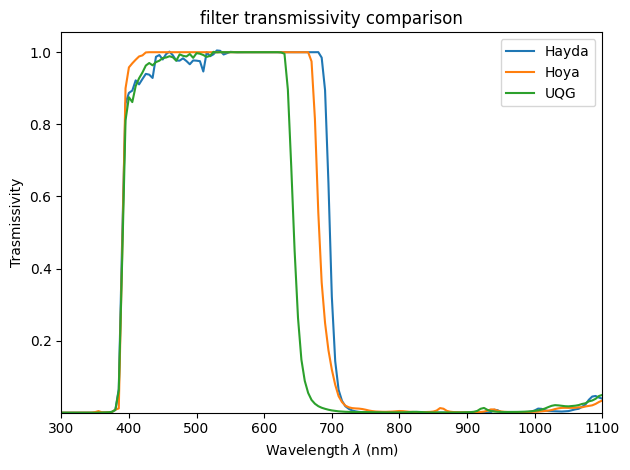

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'filter transmissivity comparison'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Trasmissivity'>)

In [2]:
filter_hayda = load_spectral_data("filter_data/Hayda.csv")
filter_hoya = load_spectral_data("filter_data/Hoya.csv")
filter_uqg = load_spectral_data("filter_data/UQG.csv")

colour.plotting.plot_multi_sds([filter_hayda, filter_hoya, filter_uqg], y_label="Trasmissivity", title="filter transmissivity comparison")

we can now also simulate the sensor response with the different filters

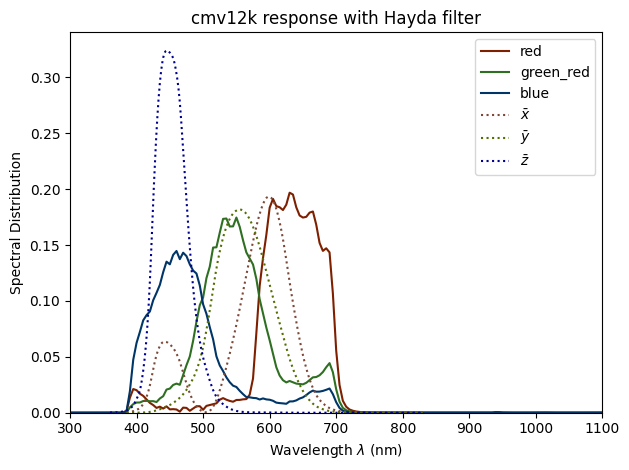

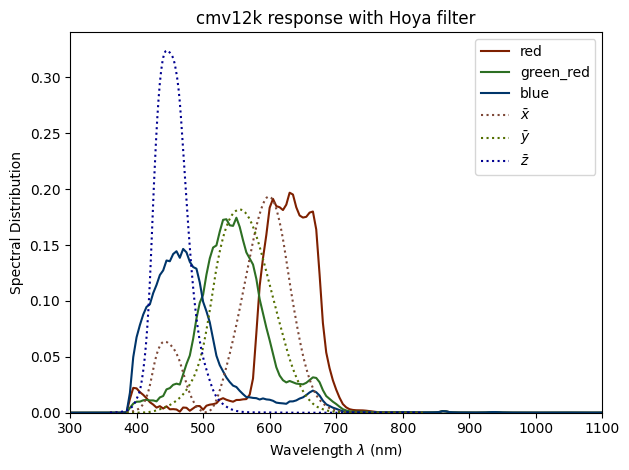

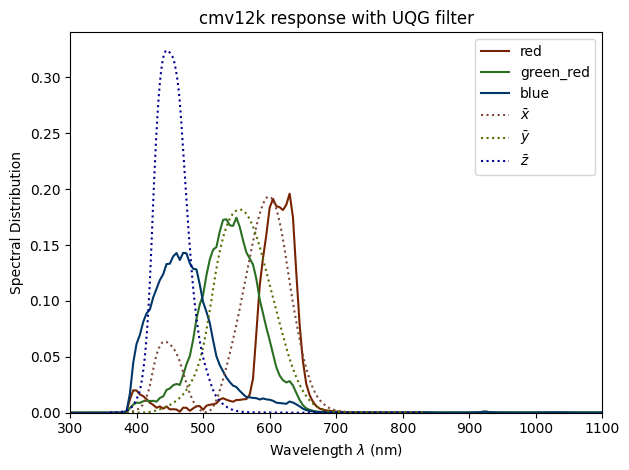

In [3]:
plot_kwargs_individual = [*([plot_kwargs] * 3), *([{'use_sd_colours': True, 'linestyle': 'dotted'}]) * 3]

for filter in [filter_hayda, filter_hoya, filter_uqg]:
    colour.plotting.plot_multi_sds(
        [
            red * filter, 
            green * filter, 
            blue * filter, 
            colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'] / 5.5
        ], 
        plot_kwargs=plot_kwargs_individual, 
        title=f"cmv12k response with {filter.name} filter"
    )

We can now simulate two photographs of a colorchecker under two different iluminants A and D65. Then we generate a color matrix from the simulated exposures. The selection of the colorchecker might not be optimal but it has the advantage, that the experiment can easily be replicated in real life to check the plausibility of the results. In the future we might want to use different color patchs that focus more on actual natural things like skin tones and foliage. For that we would need a dataset with spectral responeses of that though.

In [4]:
checkers = colour.SDS_COLOURCHECKERS
for (k, v) in checkers.items():
    first_patch = list(v.values())[0]
    print(f"'{k}' has data from {first_patch.domain[0]}nm to {first_patch.domain[-1]}nm")

'BabelColor Average' has data from 380.0nm to 730.0nm
'ColorChecker N Ohta' has data from 380.0nm to 780.0nm
'babel_average' has data from 380.0nm to 730.0nm
'cc_ohta' has data from 380.0nm to 780.0nm
'ISO 17321-1' has data from 380.0nm to 780.0nm


Sadly we only have colorchecker spectral data from 380nm to 780nm :(. This is ok though, since regardless of the filter we use, there is hardly any spectral sensitivity outside that range.
From here on, we will use the "BabelColor Average" dataset.

N_human: 10787.9432624104; N_sensor: 1637.1647418112552
A raw -> XYZ:
[[ 0.71129919  0.39114023 -0.08781981]
 [ 0.19210438  0.91446259 -0.25398029]
 [-0.01030647 -0.22976844  1.28152133]]
A XYZ -> raw:
[[ 0.71129919  0.39114023 -0.08781981]
 [ 0.19210438  0.91446259 -0.25398029]
 [-0.01030647 -0.22976844  1.28152133]]


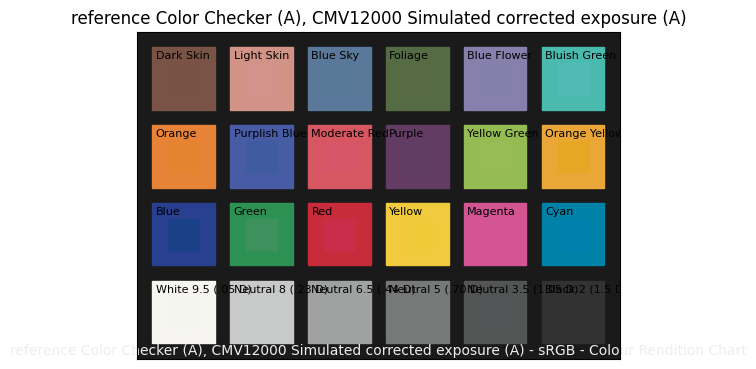

mean color distance: 1.14 (min: 0.10 @ black 2 (1.5 d); max: 4.45 @ blue; std: 1.11)

N_human: 10566.786226457249; N_sensor: 1908.3531316308158
D65 raw -> XYZ:
[[ 0.91046834  0.32171461  0.0808566 ]
 [ 0.2629515   1.01796111 -0.20854347]
 [ 0.03974485 -0.38440635  1.68158837]]
D65 XYZ -> raw:
[[ 0.91046834  0.32171461  0.0808566 ]
 [ 0.2629515   1.01796111 -0.20854347]
 [ 0.03974485 -0.38440635  1.68158837]]


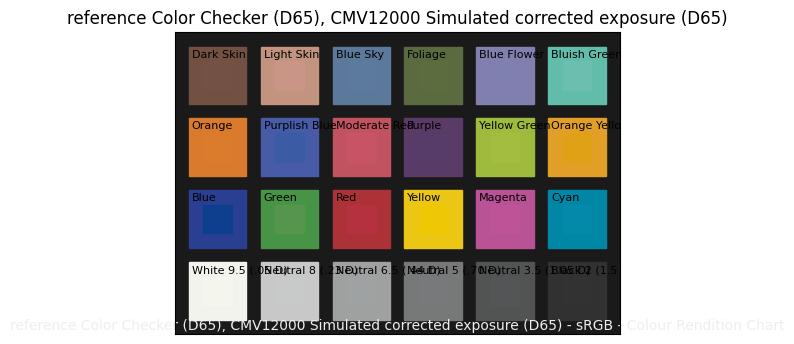

mean color distance: 1.41 (min: 0.42 @ blue sky; max: 3.40 @ blue; std: 0.93)



In [8]:
color_checker = colour.SDS_COLOURCHECKERS['BabelColor Average']
shape = colour.SpectralShape(380, 730, 5)

def align(sd):
    from copy import deepcopy
    return deepcopy(sd).align(shape)

human = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
sensor = colour.MultiSpectralDistributions([align(x) * align(filter_uqg) for x in [red, green, blue]])


def simulate_exposure(stimulus, sensitivity):
    if isinstance(sensitivity, colour.MultiSpectralDistributions):
        return np.array([simulate_exposure(stimulus, s) for s in sensitivity.to_sds()])
    elif isinstance(sensitivity, colour.SpectralDistribution):
        sensitivity, stimulus = align(sensitivity), align(stimulus)
        return np.trapz(stimulus.values * sensitivity.values, x=sensitivity.wavelengths)
    else:
        raise TypeError(f"{sensitivity} is of unsupported type")

def plot_color_checker_compare(compare_capture, iluminant):
    data_altered = {}
    data_reference = {}
    differences = {}
    for patch in color_checker.data.keys():
        sd = align(color_checker[patch])
        iluminant_sd = align(colour.SDS_ILLUMINANTS[iluminant])

        xyz = compare_capture(sd * iluminant_sd)
        data_altered[patch] = colour.XYZ_to_xyY(xyz)

        N_human = simulate_exposure(iluminant_sd, human.to_sds()[1])
        reference_xyz = (1 / 10787.9432624104) * simulate_exposure(sd * iluminant_sd, human)
        data_reference[patch] = colour.XYZ_to_xyY(reference_xyz)

        differences[patch] = colour.difference.delta_E(colour.XYZ_to_Lab(reference_xyz), colour.XYZ_to_Lab(xyz), method="CIE 2000")

    iluminant_x, illuminant_y, illuminant_Y = colour.XYZ_to_xyY(colour.sd_to_XYZ(iluminant_sd))
    altered = colour.characterisation.ColourChecker(f'CMV12000 Simulated corrected exposure ({iluminant})', data_altered, illuminant=[iluminant_x, illuminant_y])
    reference = colour.characterisation.ColourChecker(f'reference Color Checker ({iluminant})', data_reference, illuminant=[iluminant_x, illuminant_y])
    colour.plotting.plot_multi_colour_checkers([reference, altered])

    differences_list = list(differences.values())
    differences_keys = list(differences.keys())
    print(
        f"mean color distance: {np.mean(differences_list):.2f} " + 
        f"(min: {np.min(differences_list):.2f} @ {differences_keys[np.argmin(differences_list)]}; " + 
        f"max: {np.max(differences_list):.2f} @ {differences_keys[np.argmax(differences_list)]}; " + 
        f"std: {np.std(differences_list):.2f})"
    )

for iluminant in ['A', 'D65']:
    iluminant_sd = align(colour.SDS_ILLUMINANTS[iluminant])

    K = 100
    N_human = simulate_exposure(iluminant_sd, human.to_sds()[1])
    N_sensor = simulate_exposure(iluminant_sd, sensor.to_sds()[1])
    print(f"N_human: {N_human}; N_sensor: {N_sensor}")

    xyz_data = []
    raw_data = []
    for patch in color_checker.data.keys():
        xyz_data.append(colour.colorimetry.sd_to_XYZ(color_checker[patch], illuminant=iluminant_sd))
        raw_data.append((K / N_sensor) * simulate_exposure(align(color_checker[patch]) * align(iluminant_sd), sensor))
    

    def print_rust_matrix(matrix):
        for row in matrix:
            print(" ".join(f"({(round(f * 10000)):.0f}, 10000), " for f in row))

    print(f"{iluminant} raw -> XYZ:")
    print(corr_matrix := colour.matrix_colour_correction(raw_data, xyz_data))
    print(f"{iluminant} XYZ -> raw:")
    print(colour.matrix_colour_correction(raw_data, xyz_data))

    plot_color_checker_compare(lambda sd: np.dot(corr_matrix, (1 / N_sensor) * simulate_exposure(sd, sensor)), iluminant)

    print()


This already looks kind of nice, but we can still do better by trying to minimize perceptual color difference instead of just color difference in some technical implementation detail scale.

UQG
N_human: 10787.9432624104; N_sensor: 1637.1647418112552
A raw -> XYZ:
[[ 0.75694824  0.32741427 -0.04047668]
 [ 0.20857565  0.90869186 -0.27265158]
 [-0.01944907 -0.20221445  1.24995437]]


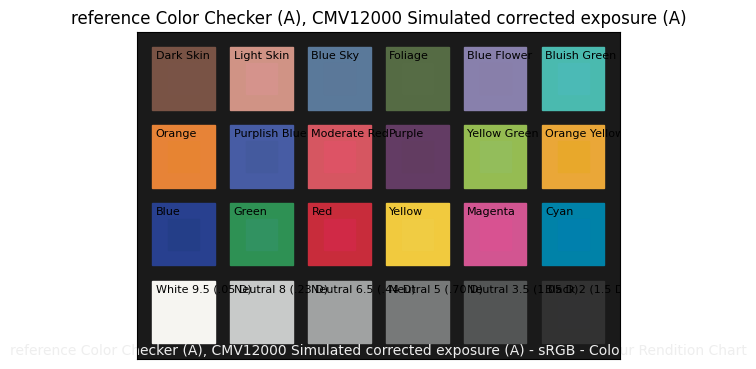

mean color distance: 0.84 (min: 0.02 @ neutral 6.5 (.44 d); max: 2.65 @ cyan; std: 0.77)
N_human: 10566.786226457249; N_sensor: 1908.3531316308158
D65 raw -> XYZ:
[[ 0.98037466  0.25807412  0.10938014]
 [ 0.30071061  0.98412467 -0.19524227]
 [ 0.0411538  -0.36326222  1.64741696]]


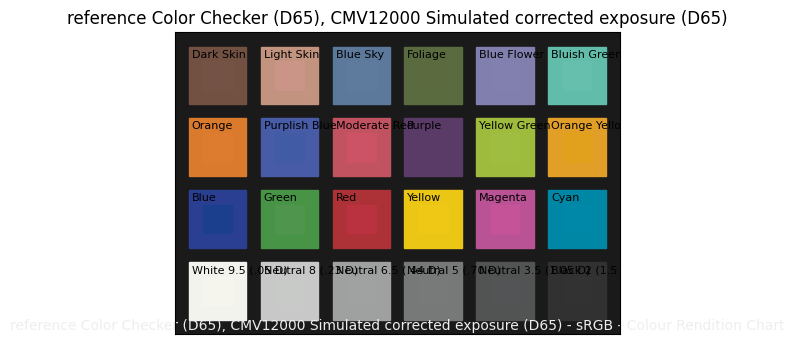

mean color distance: 1.20 (min: 0.15 @ purple; max: 3.39 @ light skin; std: 0.93)



Hayda
N_human: 10787.9432624104; N_sensor: 1980.1419148743514
A raw -> XYZ:
[[ 0.36424477  0.56157197 -0.16048256]
 [-0.00366941  1.17446171 -0.38025568]
 [-0.08605218 -0.19874507  1.46257969]]


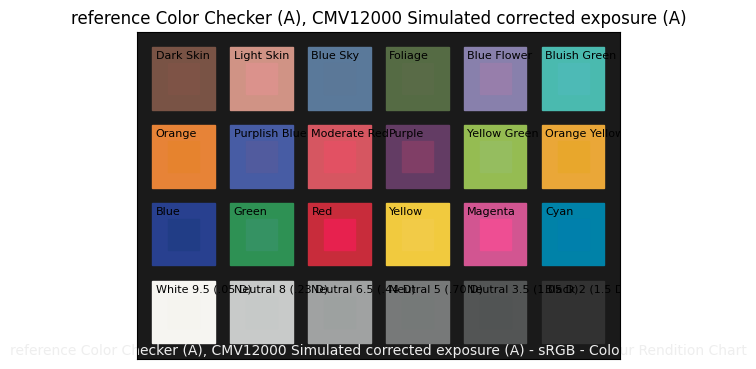

mean color distance: 2.03 (min: 0.14 @ black 2 (1.5 d); max: 6.97 @ red; std: 1.83)
N_human: 10566.786226457249; N_sensor: 2046.7770073709369
D65 raw -> XYZ:
[[ 0.50705389  0.42031895  0.07893626]
 [ 0.0659068   1.12227578 -0.2287135 ]
 [-0.03727658 -0.3511273   1.74124275]]


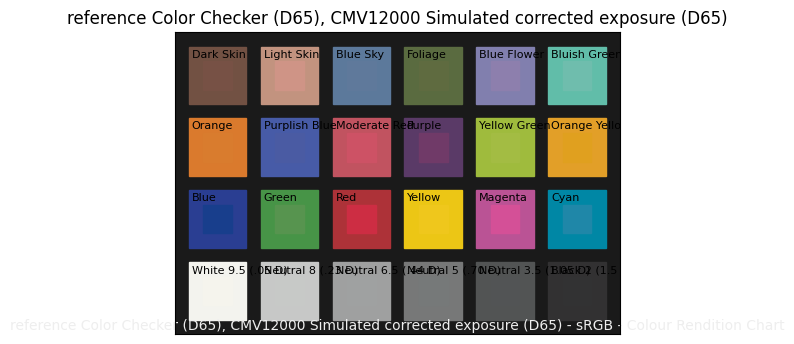

mean color distance: 2.12 (min: 0.38 @ neutral 3.5 (1.05 d); max: 6.23 @ red; std: 1.81)



Hoya
N_human: 10787.9432624104; N_sensor: 1867.7857276498887
A raw -> XYZ:
[[ 0.42076665  0.51253553 -0.14247734]
 [ 0.04481386  1.08993519 -0.34991208]
 [-0.06788889 -0.19155947  1.35747958]]


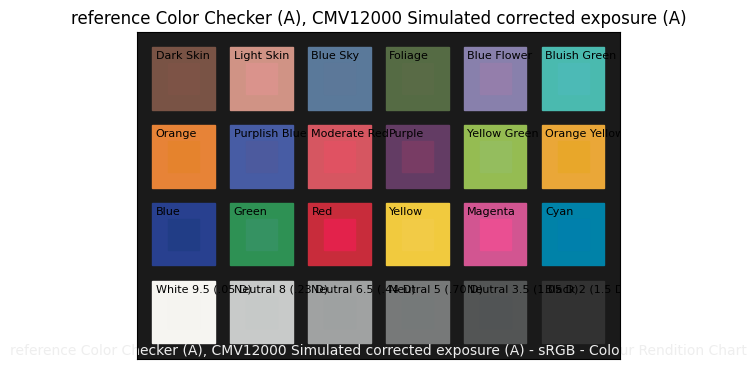

mean color distance: 1.76 (min: 0.11 @ black 2 (1.5 d); max: 6.07 @ red; std: 1.50)
N_human: 10566.786226457249; N_sensor: 2017.636841719248
D65 raw -> XYZ:
[[ 0.58466575  0.37955494  0.09144832]
 [ 0.1176412   1.08438065 -0.2177085 ]
 [-0.01182661 -0.36614196  1.69244925]]


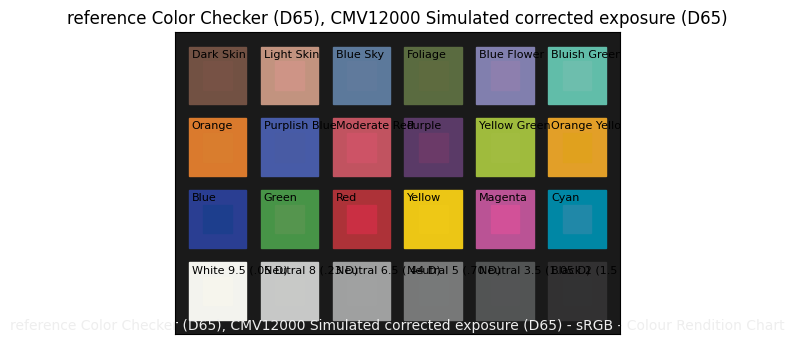

mean color distance: 1.96 (min: 0.35 @ neutral 3.5 (1.05 d); max: 5.89 @ red; std: 1.62)





In [14]:
import scipy.optimize

def find_raw_transform(raw, xyz):
    def cost(matrix):
        matrix = np.reshape(matrix, (3, 3))
        def difference_with_matrix_applied(raw, xyz):
            transformed = np.dot(matrix, raw)
            delta_e = colour.difference.delta_E(colour.XYZ_to_Lab(xyz), colour.XYZ_to_Lab(transformed), method="CIE 2000")
            return delta_e
        color_difference_sum = np.mean([difference_with_matrix_applied(raw, xyz) for raw, xyz in zip(raw, xyz)])
        return color_difference_sum
    result = scipy.optimize.minimize(cost, np.ones((9,)))
    return np.reshape(result.x, (3, 3))

for filter in [filter_uqg, filter_hayda, filter_hoya]:
    sensor = colour.MultiSpectralDistributions([align(x) * align(filter) for x in [red, green, blue]])
    print(filter.name)
    for iluminant in ['A', 'D65']:
        iluminant_sd = align(colour.SDS_ILLUMINANTS[iluminant])

        K = 100
        N_human = simulate_exposure(iluminant_sd, colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].to_sds()[1])
        N_sensor = simulate_exposure(iluminant_sd, sensor.to_sds()[1])
        print(f"N_human: {N_human}; N_sensor: {N_sensor}")

        xyz_data = []
        raw_data = []
        for patch in color_checker.data.keys():
            xyz_data.append(colour.colorimetry.sd_to_XYZ(color_checker[patch], illuminant=iluminant_sd))
            raw_data.append((K / N_sensor) * simulate_exposure(align(color_checker[patch]) * align(iluminant_sd), sensor))
        

        def print_rust_matrix(matrix):
            for row in matrix:
                print(" ".join(f"({(round(f * 10000)):.0f}, 10000), " for f in row))


        print(f"{iluminant} raw -> XYZ:")
        print(corr_matrix := find_raw_transform(raw_data, xyz_data))

        plot_color_checker_compare(lambda sd: np.dot(corr_matrix, (1 / N_sensor) * simulate_exposure(sd, sensor)), iluminant)

    print("\n\n")

Now we can evaluate some more which UV / IR cut filter results in the most accurate colours. 